In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import sys
sys.path.append('../')
from utils import get_mat
import networkx as nx

### Load data, merge experiments, calculate normalized scores

In [62]:
directory_path = '../our_results'

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)
    
    # Define the pattern
    pattern = re.compile(r'([\w-]+)_(\d+\.\d+)_(\d+\.\d+)_(\d+\.\d+)_(\d+)\.csv')

    # Use the pattern to extract values
    match = pattern.match(file)

    # Check if the string matches the pattern
    if match:
        # Extract values from the match object
        df['dataset'] = match.group(1)
        e1 = float(match.group(3))
        df['e1'] = e1
        e2 = float(match.group(4))
        df['e2'] = e2
        df['e3'] = 1.0 - e1 - e2
    else:
        print(file + " doesn't match!")
        continue
        
    dfs.append(df)

# Concatenate the list of DataFrames into a single DataFrame
dfs = pd.concat(dfs, ignore_index=True)

# take the average of all experiments
dfs = dfs.groupby(['eps', 'N', 'dataset', 'e1', 'e2']).mean().reset_index()
dfs = dfs.drop('exper', axis=1)

dfs

,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3
0,0.5,5.0,CA-HepPh,0.1,0.1,0.107244,0.014167,0.023399,3.981196,0.384615,0.999407,0.818220,0.8
1,0.5,5.0,CA-HepPh,0.1,0.2,0.110734,0.012500,0.024522,4.259935,0.438462,0.999385,0.813684,0.7
2,0.5,5.0,CA-HepPh,0.1,0.3,0.109254,0.008333,0.013324,3.505275,0.446154,0.998994,0.810664,0.6
3,0.5,5.0,CA-HepPh,0.1,0.4,0.111198,0.013333,0.030615,4.025057,0.453846,0.999141,0.813282,0.5
4,0.5,5.0,CA-HepPh,0.1,0.5,0.107882,0.010833,0.023944,3.901634,0.446154,0.999174,0.815921,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,3.5,35.0,Facebook,0.4,0.4,0.211623,0.672500,0.008383,0.332793,0.262500,0.631651,0.326553,0.2
2092,3.5,35.0,Facebook,0.4,0.5,0.242776,0.655000,0.007636,0.351442,0.150000,0.596279,0.342098,0.1
2093,3.5,35.0,Facebook,0.5,0.1,0.154159,0.712500,0.005143,0.451522,0.212500,0.525142,0.410727,0.4
2094,3.5,35.0,Facebook,0.5,0.3,0.207987,0.665000,0.008607,0.363541,0.225000,0.605318,0.335231,0.2


In [63]:
# apply Z-Score Normalization for the metrics and add graph info at the dataset level
datasets = dfs['dataset'].unique()
metrics = cols = ['nmi','evc_overlap','evc_MAE','deg_kl', 'diam_rel','cc_rel','mod_rel']
for dataset in datasets:
    data_path = '../data/' + dataset + '.txt'
    mat0,mid = get_mat(data_path)
    mat0_graph = nx.from_numpy_array(mat0,create_using=nx.Graph)
    dfs.loc[dfs['dataset'] == dataset,'nodes'] = mat0_graph.number_of_nodes()
    dfs.loc[dfs['dataset'] == dataset,'edges'] = mat0_graph.number_of_edges()
    
    # dfs.loc[dfs['dataset'] == dataset, metrics] = dfs.loc[dfs['dataset'] == dataset, metrics].apply(zscore)
    
dfs['density'] = dfs['edges']/dfs['nodes']

# invert certain metrics that are better when the values are smaller
for col in ['evc_MAE','deg_kl', 'diam_rel','cc_rel','mod_rel']:
    dfs[col] = -dfs[col]
    
# calculate a score based on normalized metrics. The larger the score the better.
dfs['score'] = dfs[metrics].sum(axis=1)

dfs

,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
0,0.5,5.0,CA-HepPh,0.1,0.1,0.107244,0.014167,-0.023399,-3.981196,-0.384615,-0.999407,-0.818220,0.8,12008.0,118489.0,9.867505,-6.085426
1,0.5,5.0,CA-HepPh,0.1,0.2,0.110734,0.012500,-0.024522,-4.259935,-0.438462,-0.999385,-0.813684,0.7,12008.0,118489.0,9.867505,-6.412754
2,0.5,5.0,CA-HepPh,0.1,0.3,0.109254,0.008333,-0.013324,-3.505275,-0.446154,-0.998994,-0.810664,0.6,12008.0,118489.0,9.867505,-5.656823
3,0.5,5.0,CA-HepPh,0.1,0.4,0.111198,0.013333,-0.030615,-4.025057,-0.453846,-0.999141,-0.813282,0.5,12008.0,118489.0,9.867505,-6.197410
4,0.5,5.0,CA-HepPh,0.1,0.5,0.107882,0.010833,-0.023944,-3.901634,-0.446154,-0.999174,-0.815921,0.4,12008.0,118489.0,9.867505,-6.068111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,3.5,35.0,Facebook,0.4,0.4,0.211623,0.672500,-0.008383,-0.332793,-0.262500,-0.631651,-0.326553,0.2,4039.0,88234.0,21.845506,-0.677757
2092,3.5,35.0,Facebook,0.4,0.5,0.242776,0.655000,-0.007636,-0.351442,-0.150000,-0.596279,-0.342098,0.1,4039.0,88234.0,21.845506,-0.549678
2093,3.5,35.0,Facebook,0.5,0.1,0.154159,0.712500,-0.005143,-0.451522,-0.212500,-0.525142,-0.410727,0.4,4039.0,88234.0,21.845506,-0.738374
2094,3.5,35.0,Facebook,0.5,0.3,0.207987,0.665000,-0.008607,-0.363541,-0.225000,-0.605318,-0.335231,0.2,4039.0,88234.0,21.845506,-0.664710


In [64]:
# top 10 combos for Chamelon
dfs[dfs['dataset'] == "Chamelon"][dfs['eps'] == 0.5].nlargest(10, "score")

/var/folders/r9/dg66n5vj32z_jl7f7k8wjsx80000gn/T/ipykernel_3709/4282099312.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfs[dfs['dataset'] == "Chamelon"][dfs['eps'] == 0.5].nlargest(10, "score")


,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
550,0.5,50.0,Chamelon,0.1,0.7,0.171291,0.418182,-0.012129,-1.600626,-0.490909,-0.282569,-0.427690,0.2,2277.0,31371.0,13.777339,-2.224450
517,0.5,45.0,Chamelon,0.1,0.8,0.171349,0.259091,-0.011159,-1.655805,-0.454545,-0.207551,-0.442970,0.1,2277.0,31371.0,13.777339,-2.341591
551,0.5,50.0,Chamelon,0.1,0.8,0.179174,0.213636,-0.012013,-1.775804,-0.472727,-0.201837,-0.455511,0.1,2277.0,31371.0,13.777339,-2.525083
516,0.5,45.0,Chamelon,0.1,0.7,0.158795,0.422727,-0.014665,-1.919735,-0.536364,-0.382338,-0.411347,0.2,2277.0,31371.0,13.777339,-2.682926
503,0.5,40.0,Chamelon,0.5,0.4,0.178453,0.195455,-0.020732,-1.974439,-0.490909,-0.188212,-0.394786,0.1,2277.0,31371.0,13.777339,-2.695171
428,0.5,35.0,Chamelon,0.2,0.7,0.172989,0.218182,-0.016970,-2.006620,-0.472727,-0.186764,-0.430477,0.1,2277.0,31371.0,13.777339,-2.722388
493,0.5,40.0,Chamelon,0.3,0.5,0.163382,0.381818,-0.019120,-1.983119,-0.518182,-0.382284,-0.435360,0.2,2277.0,31371.0,13.777339,-2.792864
528,0.5,45.0,Chamelon,0.3,0.6,0.171634,0.209091,-0.019758,-1.962962,-0.500000,-0.271275,-0.422085,0.1,2277.0,31371.0,13.777339,-2.795355
604,0.5,60.0,Chamelon,0.3,0.6,0.168208,0.222727,-0.019638,-2.024315,-0.500000,-0.263137,-0.423387,0.1,2277.0,31371.0,13.777339,-2.839542
583,0.5,55.0,Chamelon,0.3,0.6,0.167850,0.181818,-0.022539,-1.945022,-0.481818,-0.288381,-0.462223,0.1,2277.0,31371.0,13.777339,-2.850315


### Multi-Linear Regression model

Mean Squared Error: 0.2616647954631659
R-squared: 0.9230839009919682


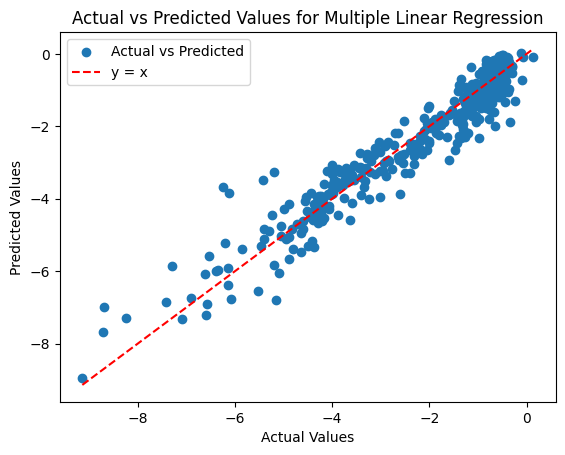

In [65]:
# construct other predictors for the model from parameters
dfs['eps*N'] = dfs['eps'] * dfs['N']
dfs['(eps*N)**2'] = dfs['eps*N']**2
dfs['eps**2'] =  np.square(dfs['eps'])
dfs['e1*e2'] = dfs['e1'] * dfs['e2']
dfs['e1**2'] = np.square(dfs['e1'])
dfs['e2**2'] = np.square(dfs['e2'])
dfs['N**2'] = np.square(dfs['N'])
dfs['N**3'] = np.power(dfs['N'], 3)
dfs['N*e1'] = dfs['N'] * (dfs['e1'] - dfs['e1**2'])
dfs['N*e2'] = dfs['N'] * (dfs['e2'] - dfs['e1**2'])
dfs['(e1+e2)/e3'] = dfs['e1'] + dfs['e2'] / dfs['e3']
dfs['e1*eps'] = dfs['e1'] * dfs['eps']
dfs['e2*eps'] = dfs['e2'] * dfs['eps']
dfs['(e1*eps)**2'] = np.square(dfs['e1*eps'])
dfs['(e2*eps)**2'] = np.square(dfs['e2*eps'])
dfs['N*e1*eps'] = dfs['N'] * dfs['e1*eps']
dfs['N*e2*eps'] = dfs['N'] * dfs['e2*eps']

variables = ['eps', 'N', 'e1', 'e2', 'eps*N', 'e1**2', 'e2**2', 'eps**2', 'e1*e2', 'N*e1', 'N*e2',\
    '(e1+e2)/e3', 'N**2', 'N**3', 'e1*eps', 'e2*eps', '(e1*eps)**2', '(e2*eps)**2', 'N*e1*eps', 'N*e2*eps', 'nodes', 'edges', 'density', '(eps*N)**2']
# Split the data into features (X) and target variable (y)
X = dfs[variables]
y = dfs['score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the predicted vs actual values
plt.scatter(y_test, y_pred, label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='y = x')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Multiple Linear Regression')
plt.legend()
plt.show()

Mean Squared Error: 0.2761465887801287
R-squared: 0.9225418389857234


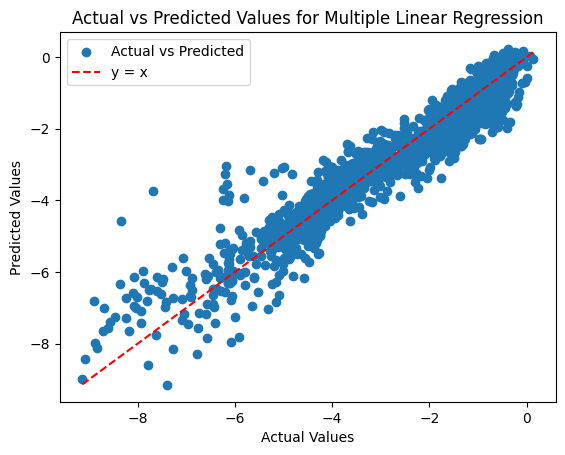

In [79]:
# the model if it had access to all the data, not just training (as good as it's gonna get?)
model2 = LinearRegression()

# Train the model
model2.fit(X, y)

# Make predictions on the test set
y_pred2 = model2.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred2)
r2 = r2_score(y, y_pred2)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the predicted vs actual values
plt.scatter(y, y_pred2, label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='y = x')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Multiple Linear Regression')
plt.legend()
plt.show()

In [67]:
# Calculate residuals
residuals = y_test - y_pred

# Calculate MSE for each data point
mse_per_point = np.square(residuals)

# Find the indices of the points with the highest MSE
indices_highest_mse = mse_per_point.nlargest(30).index   # Adjust the number of points to display

test_set = dfs.iloc[y_test.index]
test_set['pred'] = y_pred
test_set['diff'] = np.square(test_set['score'] - test_set['pred'])

/var/folders/r9/dg66n5vj32z_jl7f7k8wjsx80000gn/T/ipykernel_3709/3960316184.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['pred'] = y_pred
/var/folders/r9/dg66n5vj32z_jl7f7k8wjsx80000gn/T/ipykernel_3709/3960316184.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['diff'] = np.square(test_set['score'] - test_set['pred'])


In [69]:
# largest differences in prediction
test_set.sort_values(by='diff', ascending=False)[:17][['eps', 'N', 'dataset', 'e1', 'e2','pred', 'score', 'diff']]

,eps,N,dataset,e1,e2,pred,score,diff
1017,2.0,10.0,Facebook,0.1,0.1,-3.678035,-6.247020,6.599687
957,2.0,5.0,Facebook,0.1,0.2,-3.841428,-6.117617,5.181040
1641,3.5,5.0,Chamelon,0.1,0.1,-3.476874,-5.424187,3.792026
935,2.0,5.0,Chamelon,0.3,0.1,-3.249474,-5.196399,3.790518
47,0.5,5.0,Facebook,0.1,0.6,-7.000529,-8.688494,2.849224
142,0.5,15.0,Chamelon,0.1,0.1,-6.808540,-5.155440,2.732739
1692,3.5,5.0,Facebook,0.3,0.1,-1.875917,-0.340337,2.358007
114,0.5,10.0,Facebook,0.1,0.5,-5.849106,-7.287440,2.068806
1872,3.5,20.0,Facebook,0.1,0.1,-2.001199,-0.642063,1.847252
1032,2.0,10.0,Facebook,0.3,0.1,-2.321254,-0.972336,1.819579


In [71]:
# After training the model
coefficients = model.coef_  # Coefficients for each feature
intercept = model.intercept_  # Intercept

# Display the equation
equation = f'y = {intercept:.4f}\n'
for i, var in enumerate(variables):
    if coefficients[i] >= 0.0 :
        equation += "+ "
    equation += f'{coefficients[i]:.4f} * '+ var +"\n"
# print("Linear Regression Equation:")
print(equation)

y = -15.0388
+ 4.7733 * eps
+ 0.4369 * N
+ 11.6474 * e1
+ 6.0290 * e2
-0.0618 * eps*N
-6.5684 * e1**2
-3.5472 * e2**2
-0.6908 * eps**2
-8.2790 * e1*e2
-0.1205 * N*e1
+ 0.0618 * N*e2
+ 0.0218 * (e1+e2)/e3
-0.0097 * N**2
+ 0.0001 * N**3
+ 0.0516 * e1*eps
+ 2.0261 * e2*eps
-0.0707 * (e1*eps)**2
-0.4789 * (e2*eps)**2
-0.0227 * N*e1*eps
-0.0555 * N*e2*eps
+ 0.0001 * nodes
-0.0000 * edges
-0.0000 * density
+ 0.0003 * (eps*N)**2



In [72]:
equation = f'y = {intercept:.4f}'
for i, var in enumerate(variables):
    if coefficients[i] >= 0.0 :
        equation += "+ "
    equation += f'{coefficients[i]:.4f} * '+ var +" "
# print("Linear Regression Equation:")
print(equation)

y = -15.0388+ 4.7733 * eps + 0.4369 * N + 11.6474 * e1 + 6.0290 * e2 -0.0618 * eps*N -6.5684 * e1**2 -3.5472 * e2**2 -0.6908 * eps**2 -8.2790 * e1*e2 -0.1205 * N*e1 + 0.0618 * N*e2 + 0.0218 * (e1+e2)/e3 -0.0097 * N**2 + 0.0001 * N**3 + 0.0516 * e1*eps + 2.0261 * e2*eps -0.0707 * (e1*eps)**2 -0.4789 * (e2*eps)**2 -0.0227 * N*e1*eps -0.0555 * N*e2*eps + 0.0001 * nodes -0.0000 * edges -0.0000 * density + 0.0003 * (eps*N)**2 


### finding the a good set of parameters using scipy.optimize

In [77]:
from scipy.optimize import minimize

# Define the function to minimize
def objective_function(variables):
    eps = 2.5
    nodes = 4000
    edges = 60000
    density = 0
    N, e1, e2, e3 = variables
    y = -30.4020+ 12.8055 * eps + 0.7659 * N + 20.4504 * e1 + 10.7168 * e2 -0.0921 * eps*N -10.6752 * e1**2 -6.9766 * e2**2 -1.9768 * eps**2 -15.6803 * e1*e2 -0.2167 * N*e1 + 0.0960 * N*e2 + 0.1402 * (e1+e2)/e3 -0.0148 * N**2 + 0.0001 * N**3 + 3.1916 * e1*eps + 7.0388 * e2*eps -0.6629 * (e1*eps)**2 -1.6006 * (e2*eps)**2 -0.0997 * N*e1*eps -0.1143 * N*e2*eps + 0.0016 * nodes -0.0001 * edges -0.0000 * density + 0.0004 * (eps*N)**2 

    return -y

# Initial guess for variable values
initial_guess = [30.0, 0.4, 0.4, 0.2]

# Define bounds for the variables if needed
bounds = [ (0, 70), (0.01, 1), (0.1, 1), (0.1, 1)]

# Perform the minimization
result = minimize(objective_function, initial_guess, bounds=bounds, constraints={'type': 'eq', 'fun': lambda x: x[1] + x[2] + x[3]- 1.0 })

# Extract the optimal variable values
optimal_values = result.x

print("Optimal Variable Values:", optimal_values)
print("Minimum Value of y:", result.fun)

Optimal Variable Values: [11.95488459  0.41151761  0.48848239  0.1       ]
Minimum Value of y: -8.151483273200043


### Selecting features automatically with RFE (doesn't actually work as well)

In [548]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt


In [613]:
variables = ['eps', 'N', 'e1', 'e2', 'nodes', 'edges']
# Split the data into features (X) and target variable (y)
X = dfs[variables]
y = dfs['score']

# Create polynomial features
degree = 5  # Set the degree of polynomial features
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# Initialize the linear regression model
model = LinearRegression()

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
selector = RFE(estimator=model, step=1, n_features_to_select = 25)

# Fit RFE on the polynomial features
selector = selector.fit(X_poly, y)

# # Get the selected features
selected_features_indices = selector.support_
selected_features = X_poly[:,selected_features_indices]

In [614]:
len(selected_features_indices)

462

In [616]:
poly.powers_[selected_features_indices]

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [2, 0, 0, 1, 0, 1],
       [1, 1, 1, 0, 0, 1],
       [0, 4, 0, 0, 0, 0],
       [0, 2, 0, 1, 1, 0],
       [0, 1, 0, 2, 0, 1],
       [3, 1, 0, 0, 1, 0],
       [3, 0, 1, 0, 0, 1],
       [2, 2, 0, 0, 1, 0],
       [2, 1, 1, 0, 0, 1],
       [2, 0, 1, 0, 2, 0],
       [2, 0, 0, 2, 0, 1],
       [2, 0, 0, 1, 2, 0],
       [1, 2, 1, 0, 1, 0],
       [1, 2, 0, 1, 1, 0],
       [1, 1, 2, 0, 0, 1],
       [1, 1, 0, 2, 0, 1],
       [1, 0, 1, 1, 2, 0],
       [1, 0, 1, 1, 1, 1],
       [0, 2, 2, 0, 1, 0],
       [0, 2, 2, 0, 0, 1],
       [0, 2, 1, 1, 0, 1],
       [0, 2, 0, 2, 1, 0],
       [0, 1, 0, 3, 0, 1]])

In [617]:
X_feat = pd.DataFrame()
for ic, combo in enumerate(poly.powers_[selected_features_indices]):
    vars = []
    for i, pow in enumerate(combo):
        if pow > 0:
            var = X.columns[i] 
            if pow > 1:
                var += "**" + str(pow) 
            vars.append(var)
            
    name = '+'.join(vars)
            
    X_feat[name] = X.apply(lambda row: 
        np.sum([np.power(row[X.columns[ri]], combo[ri]) for ri in range(len(combo)) if combo[ri] > 0]), axis=1)
    # print(np.power(X, combo))
    # X_feat[name] = np.power(X, combo)
  
X_feat  

,eps,N,eps**2+e2+edges,eps+N+e1+edges,N**4,N**2+e2+nodes,N+e2**2+edges,eps**3+N+nodes,eps**3+e1+edges,eps**2+N**2+nodes,...,eps+N**2+e2+nodes,eps+N+e1**2+edges,eps+N+e2**2+edges,eps+e1+e2+nodes**2,eps+e1+e2+nodes+edges,N**2+e1**2+nodes,N**2+e1**2+edges,N**2+e1+e2+edges,N**2+e2**2+nodes,N+e2**3+edges
0,0.5,5.0,118489.35,118494.6,625.0,12033.1,118494.01,12013.125,118489.225,12033.25,...,12033.6,118494.51,118494.51,144192064.7,130497.7,12033.01,118514.01,118514.2,12033.01,118494.001
1,0.5,5.0,118489.45,118494.6,625.0,12033.2,118494.04,12013.125,118489.225,12033.25,...,12033.7,118494.51,118494.54,144192064.8,130497.8,12033.01,118514.01,118514.3,12033.04,118494.008
2,0.5,5.0,118489.55,118494.6,625.0,12033.3,118494.09,12013.125,118489.225,12033.25,...,12033.8,118494.51,118494.59,144192064.9,130497.9,12033.01,118514.01,118514.4,12033.09,118494.027
3,0.5,5.0,118489.65,118494.6,625.0,12033.4,118494.16,12013.125,118489.225,12033.25,...,12033.9,118494.51,118494.66,144192065.0,130498.0,12033.01,118514.01,118514.5,12033.16,118494.064
4,0.5,5.0,118489.75,118494.6,625.0,12033.5,118494.25,12013.125,118489.225,12033.25,...,12034.0,118494.51,118494.75,144192065.1,130498.1,12033.01,118514.01,118514.6,12033.25,118494.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,3.5,35.0,88246.65,88272.9,1500625.0,5264.4,88269.16,4116.875,88277.275,5276.25,...,5267.9,88272.66,88272.66,16313525.3,92277.3,5264.16,89459.16,89459.8,5264.16,88269.064
1484,3.5,35.0,88246.75,88272.9,1500625.0,5264.5,88269.25,4116.875,88277.275,5276.25,...,5268.0,88272.66,88272.75,16313525.4,92277.4,5264.16,89459.16,89459.9,5264.25,88269.125
1485,3.5,35.0,88246.35,88273.0,1500625.0,5264.1,88269.01,4116.875,88277.375,5276.25,...,5267.6,88272.75,88272.51,16313525.1,92277.1,5264.25,89459.25,89459.6,5264.01,88269.001
1486,3.5,35.0,88246.55,88273.0,1500625.0,5264.3,88269.09,4116.875,88277.375,5276.25,...,5267.8,88272.75,88272.59,16313525.3,92277.3,5264.25,89459.25,89459.8,5264.09,88269.027
